<img src="logo_pós_FACENS-300x188.png">

# FACENS | FACULDADE DE ENGENHARIA DE SOROCABA

## Pós graduação em Inteligência Artificial Aplicada
## Leonardo Favero Bocardi - 120767

## Transformando um dataset de detecção de objetos em um problema de classificação de imagens por rede neural utilizando a arquitetura tensorflow datasets com arquivos tfrecords

---

A [detecção de objetos](https://docs.microsoft.com/pt-br/dotnet/machine-learning/tutorials/object-detection-onnx) é um problema da pesquisa visual computacional. Embora esteja bem relacionada à classificação de imagem, a detecção de objetos executa a classificação de imagem em uma escala mais granular. A detecção de objetos localiza e categoriza entidades dentro de imagens. No entanto, este tipo de solução pode ter um custo computacional muito elevado. A proposta deste trabalho é trazer uma solução menos custosa e mais rápida para um problema em que a localização do objeto na imagem não é necessária. Então, será feita a transformação dos dados originalmente atribuídos para a realização de detecção e classificação, para aplicar <b>somente a classificação</b> da seção da imagem contendo apenas o objeto alvo.

Modelos de detecção e classificação de objetos são comumente treinados usando aprendizado profundo, ou *deep learning*, e redes neurais.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import os
import io
import tempfile
import shutil
import glob

from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw, ImageFont
from datetime import datetime
from tqdm import tqdm
from livelossplot import PlotLossesKerasTF

%matplotlib inline

---

## O arquivo de anotações dos objetos

Em uma aplicação de detecção e classificação de objetos são necessárias informações que servirão como base para o treinamento do modelo de rede neural. Tais informações são anotadas manualmente, fazendo a localização e anotação de cada objeto alvo dentro da imagem, e podem ser feitas através de softwares específicos. Basicamente o dado processado irá conter o nome e caminho da imagem, e as dimensões de cada objeto alvo que foi identificado na imagem, além de conter o nome da classe daquele objeto.<br> O exemplo abaixo mostra de maneira visual o arquivo de anotação que será utilizado neste projeto.
<br>O [dataset](https://hci.iwr.uni-heidelberg.de/node/6132/download/00e5a82ec99a900efad8348c1b237d24) aqui utilizado possui distribuição livre para fins não comerciais.

<img src="yaml_format.png">

Para este estudo será feito o pré-processamento dos dados no arquivo que está em formato .yaml, é importante ressaltar que ele poderia ser em formato .json ou .csv.<br> 
O caminho da imagem precisa ser modificado para representar a localização real do diretório do projeto. E também será feito o treinamento do modelo somente para objetos que não estão escondidos, ou seja, em que a *tag* "occluded" seja anotada como "False".
Será mantido o formato de anotação das dimensões e o tratamento das imagens irá levar em consideração o diagrama abaixo:

(x_min, y_min)<br>
*-------------------------------------<br>
|&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
|<br>
|&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
|<br>
|------------------------------------ *
&emsp;(x_max, y_max)

---

## Visualização e pré-processamento dos dados

Para facilitar o pré-processamento dos dados anotados, o arquivo .yaml será carregado como um Pandas DataFrame.

In [2]:
with open('test.yaml', 'r') as f:
    df = pd.json_normalize(yaml.load(f, Loader=yaml.FullLoader))

df.head()

,boxes,path
0,"[{'label': 'Green', 'occluded': False, 'x_max'...",/net/pal-soc1.us.bosch.com/ifs/data/Shared_Exp...
1,"[{'label': 'Green', 'occluded': False, 'x_max'...",/net/pal-soc1.us.bosch.com/ifs/data/Shared_Exp...
2,"[{'label': 'Green', 'occluded': False, 'x_max'...",/net/pal-soc1.us.bosch.com/ifs/data/Shared_Exp...
3,"[{'label': 'Green', 'occluded': False, 'x_max'...",/net/pal-soc1.us.bosch.com/ifs/data/Shared_Exp...
4,"[{'label': 'Green', 'occluded': False, 'x_max'...",/net/pal-soc1.us.bosch.com/ifs/data/Shared_Exp...


Pode-se notar que existem imagens que não possuem anotações. Estas linhas serão removidas.

In [3]:
df.tail()

,boxes,path
8329,[],/net/pal-soc1.us.bosch.com/ifs/data/Shared_Exp...
8330,[],/net/pal-soc1.us.bosch.com/ifs/data/Shared_Exp...
8331,[],/net/pal-soc1.us.bosch.com/ifs/data/Shared_Exp...
8332,[],/net/pal-soc1.us.bosch.com/ifs/data/Shared_Exp...
8333,[],/net/pal-soc1.us.bosch.com/ifs/data/Shared_Exp...


In [4]:
df = df[df['boxes'].map(lambda d: len(d)) > 0]

In [5]:
df.tail()

,boxes,path
8186,"[{'label': 'Green', 'occluded': False, 'x_max'...",/net/pal-soc1.us.bosch.com/ifs/data/Shared_Exp...
8187,"[{'label': 'Green', 'occluded': True, 'x_max':...",/net/pal-soc1.us.bosch.com/ifs/data/Shared_Exp...
8188,"[{'label': 'Green', 'occluded': True, 'x_max':...",/net/pal-soc1.us.bosch.com/ifs/data/Shared_Exp...
8189,"[{'label': 'Green', 'occluded': True, 'x_max':...",/net/pal-soc1.us.bosch.com/ifs/data/Shared_Exp...
8190,"[{'label': 'Green', 'occluded': True, 'x_max':...",/net/pal-soc1.us.bosch.com/ifs/data/Shared_Exp...


Pode-se notar também que dentro da coluna "boxes" existe um dicionário contendo informações como a classe do objeto, suas dimensões e caminho da imagem. Esta coluna não será necessária após a aplicação da função [explode](https://stackoverflow.com/questions/12680754/split-explode-pandas-dataframe-string-entry-to-separate-rows) que irá separar os itens e valores deste dicionário em colunas únicas. Da mesma maneira que não será necessário manter quaisquer objetos em que a marcação "occluded" esteja anotada como "True".

In [6]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    idx_cols = df.columns.difference(lst_cols)
    lens = df[lst_cols[0]].str.len()
    idx = np.repeat(df.index.values, lens)
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    if (lens == 0).any():
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    res = res.sort_index()
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

In [7]:
df = explode(df, 'boxes', fill_value='')
df = pd.concat([df.drop('boxes', axis=1), pd.DataFrame(df['boxes'].tolist())], axis=1)
df.head()

,path,label,occluded,x_max,x_min,y_max,y_min
0,/net/pal-soc1.us.bosch.com/ifs/data/Shared_Exp...,Green,False,752.250,749.000,355.125,345.125
1,/net/pal-soc1.us.bosch.com/ifs/data/Shared_Exp...,Green,False,752.625,748.875,354.250,343.375
2,/net/pal-soc1.us.bosch.com/ifs/data/Shared_Exp...,Green,False,753.875,750.000,355.625,346.375
3,/net/pal-soc1.us.bosch.com/ifs/data/Shared_Exp...,Green,False,754.500,750.875,359.375,349.250
4,/net/pal-soc1.us.bosch.com/ifs/data/Shared_Exp...,Green,False,754.750,751.000,361.875,351.500


In [8]:
df = df[df['occluded'] == False]
df = df.drop('occluded', axis=1)
df.head()

,path,label,x_max,x_min,y_max,y_min
0,/net/pal-soc1.us.bosch.com/ifs/data/Shared_Exp...,Green,752.250,749.000,355.125,345.125
1,/net/pal-soc1.us.bosch.com/ifs/data/Shared_Exp...,Green,752.625,748.875,354.250,343.375
2,/net/pal-soc1.us.bosch.com/ifs/data/Shared_Exp...,Green,753.875,750.000,355.625,346.375
3,/net/pal-soc1.us.bosch.com/ifs/data/Shared_Exp...,Green,754.500,750.875,359.375,349.250
4,/net/pal-soc1.us.bosch.com/ifs/data/Shared_Exp...,Green,754.750,751.000,361.875,351.500


Por fim, o caminho da imagem será alterado para representar o caminho real do diretório deste projeto.

In [9]:
df['path'] = df['path'].apply(lambda x: "rgb/test/" + x.split("/")[-1])
df.head()

,path,label,x_max,x_min,y_max,y_min
0,rgb/test/24068.png,Green,752.250,749.000,355.125,345.125
1,rgb/test/24070.png,Green,752.625,748.875,354.250,343.375
2,rgb/test/24072.png,Green,753.875,750.000,355.625,346.375
3,rgb/test/24074.png,Green,754.500,750.875,359.375,349.250
4,rgb/test/24076.png,Green,754.750,751.000,361.875,351.500


Também será feita uma função para padronização das classes existentes.

In [10]:
def transform_labels(df):
    df.loc[(df['label'] == 'GreenLeft'),'label'] = 'Green'
    df.loc[(df['label'] == 'GreenRight'),'label'] = 'Green'
    df.loc[(df['label'] == 'GreenStraight'),'label'] = 'Green'
    df.loc[(df['label'] == 'GreenStraightLeft'),'label'] = 'Green'
    df.loc[(df['label'] == 'GreenStraightRight'),'label'] = 'Green'
    df.loc[(df['label'] == 'RedLeft'),'label'] = 'Red'
    df.loc[(df['label'] == 'RedRight'),'label'] = 'Red'
    df.loc[(df['label'] == 'RedStraight'),'label'] = 'Red'
    df.loc[(df['label'] == 'RedStraightLeft'),'label'] = 'Red'
    
    return df

## Distribuição das classes

<AxesSubplot:xlabel='label', ylabel='count'>

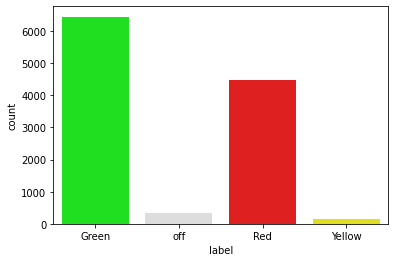

In [11]:
colors = ["#00FF00", "#DDDDDD", "#FF0000", "#FFFF00"]
sns.countplot(data=df, x='label', palette=colors)

Pelo gráfico acima, pode-se observar um grande desbalanceamento nas classes deste dataset, com poucos objetos das classes "off" e "Yellow". Este fato é explicado, visto que a aquisição dos dados foi feita para simular um problema do cotidiano, de maneira mimética.<br>
Este tipo de distruibuição apresentará disparidade entre precisão e acurácia do modelo, métricas estas que serão analisados após o treinamento e predição dos dados.

---

## Visualização e pré-processamento das imagens originais

Para o treinamento do modelo de rede neural de classificação de imagem, será utilizada a técnica de *transfer learning* com o modelo [Keras MobileNetV2](https://keras.io/api/applications/mobilenet/#mobilenetv2-function). Este modelo irá receber como entrada a imagem do objeto e sua classe previamente rotulada.
Para isto, será feito o *crop* de cada objeto dentro de cada imagem do dataset, seguindo as dimensões anotadas. Estas imagens recortadas serão redimensionadas para 128 pixels e salvas em uma pasta temporária do sistema operacional, e então transformadas em um arquivo do tipo [tfrecords](https://www.tensorflow.org/tutorials/load_data/tfrecord). 
Este arquivo grava as informações de entrada do modelo de forma binária, ou seja, cada imagem será decodificada em bytes e sua respectiva classe será transformada no formato *one-hot encoding*.
Tal estratégia otimiza o tempo de processamento dos dados e espaço utilizado em disco, atingindo assim o objetivo inicial deste trabalho.

In [12]:
def crop_box(image, bounding_box):
    image = Image.open(image)
    image = image.convert('RGB')
    
    x_max, x_min, y_max, y_min = bounding_box
    img_out = image.crop((x_min, y_min, x_max, y_max))
    
    return img_out

def make_square(im, min_size=128):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGB', (size, size), (0, 0, 0))
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    img = new_im.resize((128, 128), Image.ANTIALIAS)
    return img

In [13]:
def draw_box(image_path, bounding_boxes, labels):
    colors = {
        "Red": "#FF0000",
        "Green": "#00FF00",
        "Yellow": "#FFFF00",
        "off": "#DDDDDD" #cinza
    }
    font = ImageFont.truetype("Arial.ttf", 20)
    
    im = Image.open(image_path)
    draw = ImageDraw.Draw(im)
    
    for bounding_box, label in zip(bounding_boxes, labels):
        
        x_max, x_min, y_max, y_min = bounding_box
        draw.rectangle(((x_min, y_min), (x_max, y_max)), outline=colors[label])
        draw.text((x_min + 10, y_min + 5), label, font=font)

    return im

Todo o processo de pré-processamento das imagens pode ser observado passo a passo na sequência abaixo, onde é mostrada a imagem original, em seguida a imagem original com suas respectivas anotações (função draw_box), posteriormente somente o objeto recortado (função crop_box) e por fim o objeto redimensionado para uma imagem quadrada de 128 px com preenchimento em preto (função make_square).

imagem original


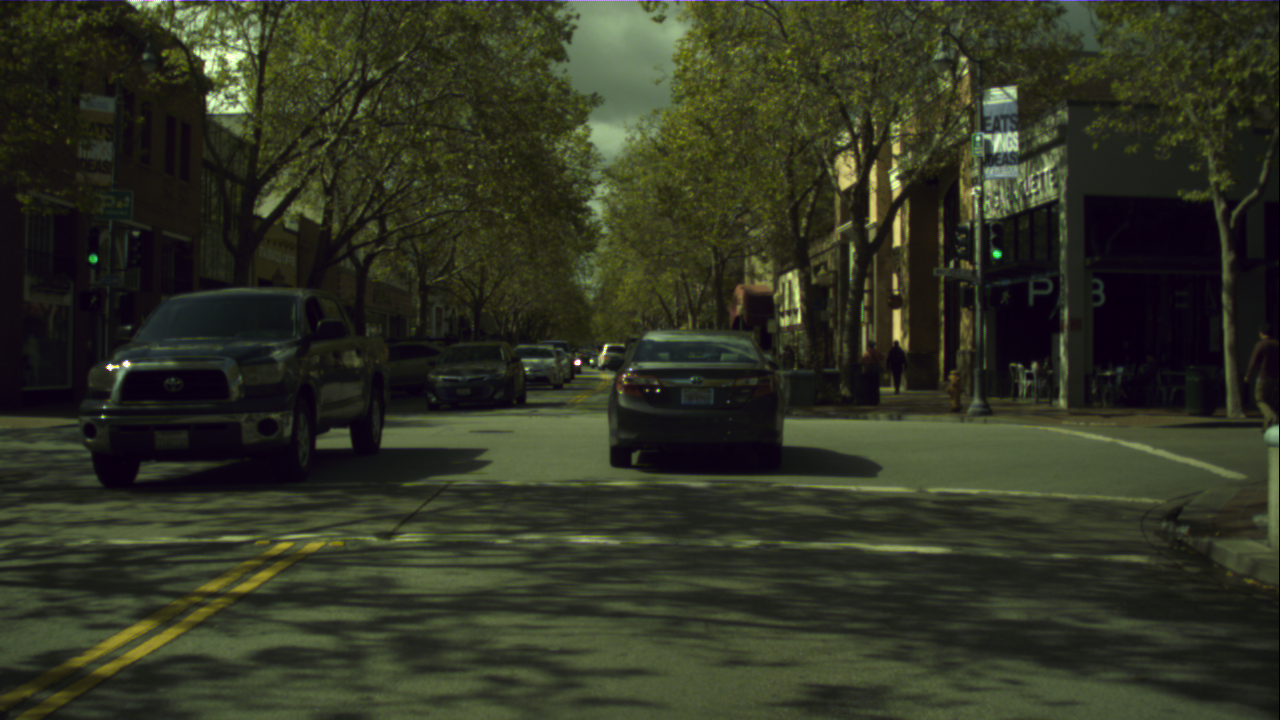

anotações do objetos


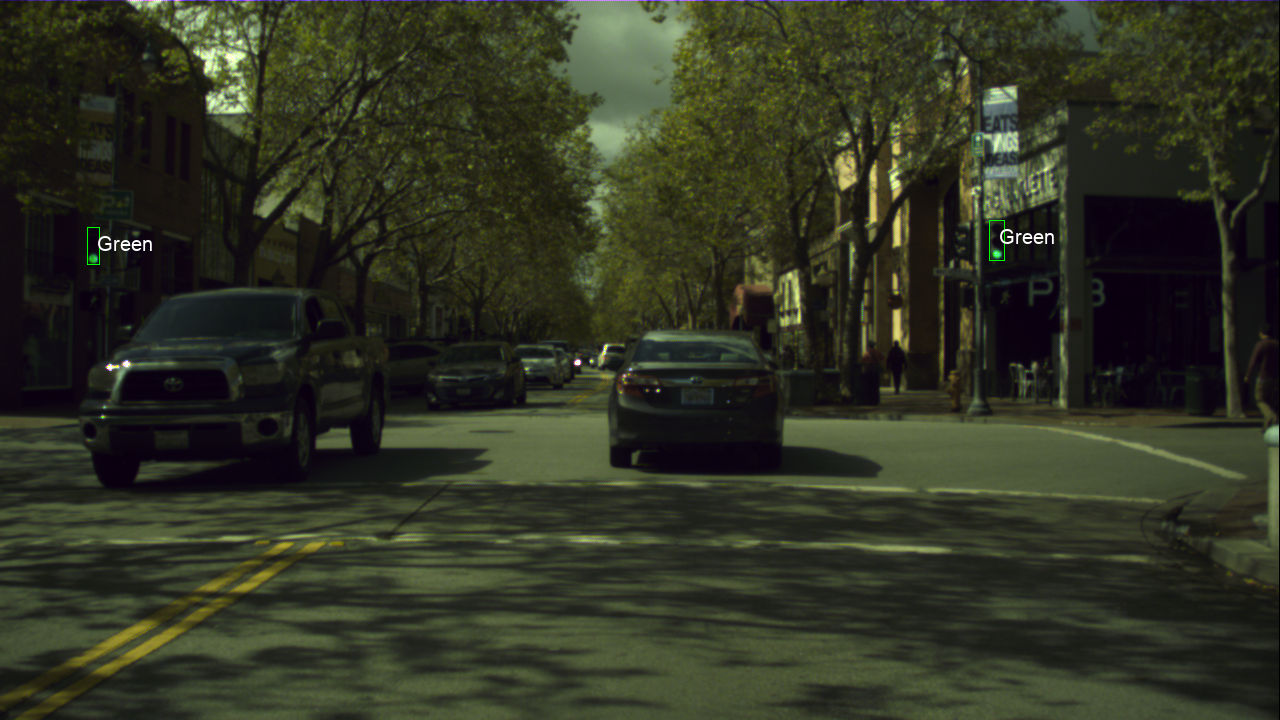

objetos recortados e redimensionados


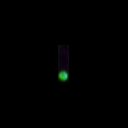

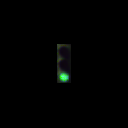

In [14]:
i = 4328 # índice da imagem escolhida como exemplo

image_name = df["path"].unique()[i]
bounding_boxes = [(x.x_max, x.x_min, x.y_max, x.y_min) for k, x in df[df["path"] == image_name].iterrows()]
labels = [(x.label) for k, x in df[df["path"] == image_name].iterrows()]

print("imagem original")
display(Image.open(image_name))
print("anotações do objetos")
display(draw_box(image_name, bounding_boxes, labels))
print("objetos recortados e redimensionados")
for bounding_box, label in zip(bounding_boxes, labels):
    cropped_image = crop_box(image_name, bounding_box)
    display(cropped_image)
    squared_image = make_square(cropped_image)
    display(squared_image)

---

## Preparação dos objetos formatados em subpastas para cada classe

O processo abaixo irá realizar todos os passos de pré-processamento de dados mencionados acima em uma única função, e então será iniciado o tratamento das imagens e o resultado será salvo em um diretório temporário do sistema na estrutura demonstrada abaixo:

tempdir<br>
&emsp;|- split_datasets<br>
&emsp;&emsp;|- train<br>
&emsp;&emsp;&emsp;|- Red<br>
&emsp;&emsp;&emsp;|- Green<br>
&emsp;&emsp;&emsp;|- Yellow<br>
&emsp;&emsp;&emsp;|- off<br>
&emsp;&emsp;|- val<br>
&emsp;&emsp;&emsp;|- Red<br>
&emsp;&emsp;&emsp;|- Green<br>
&emsp;&emsp;&emsp;|- Yellow<br>
&emsp;&emsp;&emsp;|- off

In [15]:
def read_format_annotations(set_name):
    with open(f'{set_name}.yaml', 'r') as f:
        df = pd.json_normalize(yaml.load(f, Loader=yaml.FullLoader))
    
    df = df[df['boxes'].map(lambda d: len(d)) > 0]
    
    df = explode(df, 'boxes', fill_value='')
    df = pd.concat([df.drop('boxes', axis=1), pd.DataFrame(df['boxes'].tolist())], axis=1)
    
    df = df[df['occluded'] == False]
    df = df.drop('occluded', axis=1)
    
    df = transform_labels(df)

    df['path'] = df['path'].apply(lambda x: f"rgb/{set_name}/" + x.split("/")[-1])
    
    return df

In [16]:
temp_path = tempfile.mkdtemp()

if not os.path.exists(os.path.join(temp_path, "split_datasets")):
    os.makedirs(os.path.join(temp_path, "split_datasets"))
    os.makedirs(os.path.join(temp_path, "split_datasets", "test"))
    os.makedirs(os.path.join(temp_path, "split_datasets", "train"))

for file in glob.glob(os.path.join("dataset", "*.tfrecord-000*")):
    os.remove(file)
    
for set_name in ["test", "train"]:
    
    df = read_format_annotations(set_name)
    
    for i in tqdm(range(0, df.shape[0]), desc=f'{set_name}'):
        
        bounding_box = df.iloc[i][["x_max", "x_min", "y_max", "y_min"]]
        label = df.iloc[i]["label"]

        cropped_image = crop_box(df.iloc[i, 0], bounding_box)
        squared_image = make_square(cropped_image)

        file_name = df.iloc[0, 0].split("/")[-1].replace(".png", "") + "_" + str(i)

        if not os.path.exists(os.path.join(temp_path, "split_datasets", set_name, label)):
            os.makedirs(os.path.join(temp_path, "split_datasets", set_name, label))

        squared_image.save(os.path.join(temp_path, "split_datasets", set_name, label, file_name + ".jpg"))

train: 100%|██████████| 10586/10586 [09:05<00:00, 19.42it/s]


---

## Transformação dos dados para o formato tfrecords

As funções de criação e preenchimento dos arquivos .tfrecords estão respectivamente declaradas abaixo. Uma vez que foram finalizadas as técnicas de processamento das imagens e foram salvas em um diretótio temporário do sistema, pode-se iniciar a criação dos arquivos .tfrecords.

In [17]:
def write_tfrecords(set_name, recordPath, recordFileNum, writer, classes, temp_path):

    bestNum = 1000
    num = 0

    cwd = os.path.join(os.path.join(temp_path, f"split_datasets/{set_name}"))

    for name, label in classes.items():
        class_path = os.path.join(cwd, name)
        for img_name in os.listdir(class_path):
            num += 1
            if num > bestNum:
                num = 1
                recordFileNum += 1
                writer = tf.io.TFRecordWriter(os.path.join(recordPath, f"{set_name}.tfrecord-000" + str(recordFileNum)))
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path, "r")
            img_raw_arr = io.BytesIO()
            img.save(img_raw_arr, format="jpeg")
            img_raw_arr = img_raw_arr.getvalue()
            example = tf.train.Example(features=tf.train.Features(feature={
                "img_raw": tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw_arr])),
                "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))})
            )
            writer.write(example.SerializeToString())
    writer.close()

In [18]:
def create_tfrecords(set_name, temp_path):

    recordPath = os.path.join(os.path.abspath(os.path.dirname("__file__")), "dataset")
    
    if not os.path.exists(recordPath):
        os.makedirs(recordPath)
    
    recordFileNum = 0
    keys = ["Red", "Green", "Yellow", "off"]
    values = [i for i in list(range(len(keys)))]
    classes = dict(zip(keys, values))

    writer = tf.io.TFRecordWriter(os.path.join(recordPath, f"{set_name}.tfrecord-000" + str(recordFileNum)))
    write_tfrecords(set_name, recordPath, recordFileNum, writer, classes, temp_path)

In [19]:
for set_name in ["test", "train"]:
    create_tfrecords(set_name, temp_path)

## Lendo uma entrada do tfrecord como exemplo

In [20]:
raw_dataset = tf.data.TFRecordDataset(os.path.join("dataset", "train.tfrecord-0000"))

for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

features {
  feature {
    key: "img_raw"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\010\006\006\007\006\005\010\007\007\007\t\t\010\n\014\024\r\014\013\013\014\031\022\023\017\024\035\032\037\036\035\032\034\034 $.\' \",#\034\034(7),01444\037\'9=82<.342\377\333\000C\001\t\t\t\014\013\014\030\r\r\0302!\034!22222222222222222222222222222222222222222222222222\377\300\000\021\010\000\200\000\200\003\001\"\000\002\021\001\003\021\001\377\304\000\037\000\000\001\005\001\001\001\001\001\001\000\000\000\000\000\000\000\000\001\002\003\004\005\006\007\010\t\n\013\377\304\000\265\020\000\002\001\003\003\002\004\003\005\005\004\004\000\000\001}\001\002\003\000\004\021\005\022!1A\006\023Qa\007\"q\0242\201\221\241\010#B\261\301\025R\321\360$3br\202\t\n\026\027\030\031\032%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\203\204\205\206\207\210\211\212\222\223\224\225\226\227\230\231\232\242\243\244\245\246\247\25

Como previamente dito, pode-se observar que a entrada da imagem está decodificada em bytes e sua respectiva classe ainda é expressada como um número inteiro, para posteriormente ser convertida no formato *one-hot encoding*.

---

## Funções para ler os arquivos tfrecords e carregá-los no formato tensorflow.dataset

Após a criação dos arquivos tfrecords, deve-se fazer o carregamento em uma outra estrutura de dado chamada [tensorflow.dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) que facilita a leitura de um grande número de dados. Para isso, algumas funções são declaradas abaixo. Mais um passo de processamento de dados é feito ao converter a variável de classe de inteiro para *one-hot encoding*.

In [21]:
ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [128, 128, 3])
    return image

def read_tfrecord(example):
    features={
            "img_raw": tf.io.FixedLenFeature([], tf.string),
            "label": tf.io.FixedLenFeature([], tf.int64)}
    example = tf.io.parse_single_example(example, features)
    image = decode_image(example['img_raw'])
    label = example["label"]
    label = tf.one_hot(label, depth=4)

    return image, label

def load_dataset(filenames, batch_size, repeat=False):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.experimental.AUTOTUNE)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_tfrecord)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=10*batch_size)
    if(repeat):
        dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    return dataset

---

## Carregando as entradas do modelo de classificação

In [22]:
train_filenames=(tf.io.gfile.glob("dataset"+'/train.tfrecord*'))
validation_filenames=(tf.io.gfile.glob("dataset"+'/test.tfrecord*'))

In [23]:
dataset = load_dataset(train_filenames, batch_size=32, repeat=True)
validation_dataset = load_dataset(validation_filenames, batch_size=32)

## Criação da arquitetura do modelo de classificação MobileNetV2

Como mencionado anteriormente, abaixo será declarada a estrutura do modelo de classificação keras MobileNetV2.
Este modelo receberá como entrada os arquivos tensorflow.dataset.
<br>O modelo pré-treinado MobileNetV2 possui originalmente 1000 classes, portanto a arquitetura do modelo foi alterada para treinar somente 4 classes conforme a necessidade do projeto. Também foram inseridas camadas adicionais para que se tornasse possível realizar o treinamento somente com as classes necessárias.
O modelo base será inserido sobre um novo modelo sequencial e serão adicionadas as camadas [Dropout](https://keras.io/api/layers/regularization_layers/dropout/), [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/) e [Dense](https://keras.io/api/layers/core_layers/dense/).
<br>A compilação do modelo irá trazer sua respectiva acurácia levando em consideração todas as classes treinadas.

In [24]:
model = tf.keras.applications.MobileNetV2(
  input_shape=[128, 128, 3],
  include_top=False,
  classes=4,
  weights="imagenet",
  classifier_activation="softmax")
model.trainable = False

new_model = tf.keras.models.Sequential()
new_model.add(model)
new_model.add(tf.keras.layers.Dropout(.25))
new_model.add(tf.keras.layers.Flatten())
new_model.add(tf.keras.layers.Dense(units = 4 , activation = 'softmax'))

new_model.compile(
  optimizer = tf.keras.optimizers.Adam(lr=.001),
  loss = 'categorical_crossentropy',
  metrics=['categorical_accuracy']
)

new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20480)             0         
_________________________________________________________________
dense (Dense)                (None, 4)                 81924     
Total params: 2,339,908
Trainable params: 81,924
Non-trainable params: 2,257,984
_________________________________________________________________


Um [callback](https://keras.io/api/callbacks/) é adicionado para interromper o treinamento caso a variável monitorada não tenha grandes alterações de valor.

In [25]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min",
                                        patience=5,
                                        restore_best_weights=True)

---

## Treinando o modelo

O modelo será treinado com 50 épocas fazendo 350 passos para o treinamento e 250 para a validação. É importante infatizar que o *callback* de *earlystopping* poderá interromper o treinamento caso ele atinja um plateau na variável monitorada.

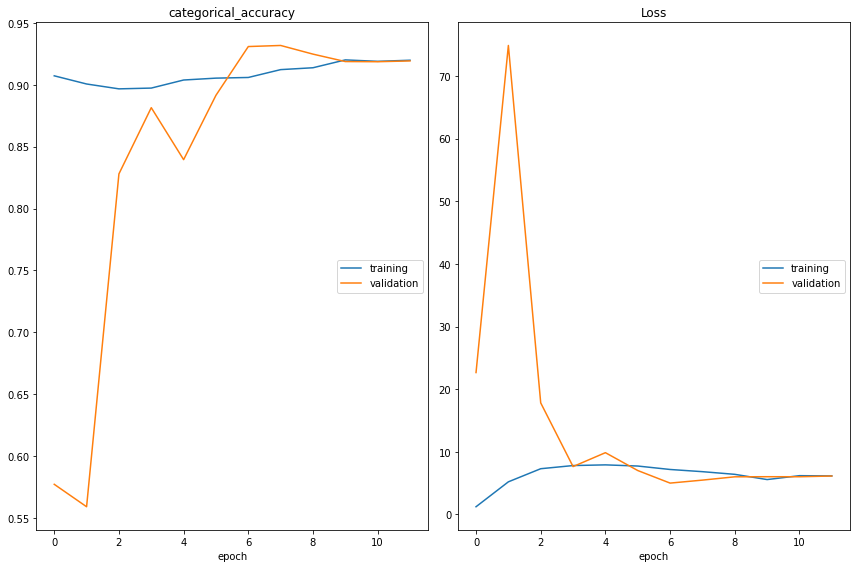

categorical_accuracy
	training         	 (min:    0.897, max:    0.920, cur:    0.920)
	validation       	 (min:    0.559, max:    0.932, cur:    0.919)
Loss
	training         	 (min:    1.225, max:    7.911, cur:    6.147)
	validation       	 (min:    5.000, max:   74.886, cur:    6.130)
350/350 [==============================] - 191s 546ms/step - loss: 6.1470 - categorical_accuracy: 0.9198 - val_loss: 6.1304 - val_categorical_accuracy: 0.9193


In [26]:
history = new_model.fit(dataset,
                        epochs=50,
                        steps_per_epoch=350,
                        validation_data=validation_dataset,
                        validation_steps=250,
                        verbose=1,
                        callbacks=[earlystopping, PlotLossesKerasTF()]
                       )

Analisando as estatísticas do treinamento do modelo, pode-se observar que houve uma convergência entre as curvas de treinamento e validação ao decorrer das épocas, tanto para a acurácia quanto para a perda. Isso mostra que não houve *overfitting* do modelo, e ele conseguiu aprender com o dataset inserido.<br>
Também podemos observar que, apesar de inicialmente ser programado para treinar com 50 épocas, o treinamento do modelo foi interrompido após apenas 11 épocas, isso se dá ao fato da métrica monitorada na função *earlystopping* ter atingido um plateau. 

---

## Prevendo e avaliando os resultados

As métricas de avaliação serão calculadas pelo tensorflow. Seguindo as funções [Precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [Recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall), [True Positives](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/TruePositives), [False Positives](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/FalsePositives), [True Negatives](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/TrueNegatives) e [False Negatives](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/FalseNegatives). 
Também será plotada a matriz de confusão através da função [Confusion Matrix](https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix), também do tensorflow.

In [27]:
y_true = np.concatenate([y for x, y in validation_dataset], axis=0)
y_pred = new_model.predict(validation_dataset)

In [28]:
def get_classification_precision(val_true, val_pred):
    m = tf.keras.metrics.Precision()
    m.update_state(val_true, val_pred)

    return m.result().numpy()


def get_classification_recall(val_true, val_pred):
    m = tf.keras.metrics.Recall()
    m.update_state(val_true, val_pred)

    return m.result().numpy()


def get_classification_truepositives(val_true, val_pred):
    m = tf.keras.metrics.TruePositives()
    m.update_state(val_true, val_pred)

    return m.result().numpy()


def get_classification_falsepositives(val_true, val_pred):
    m = tf.keras.metrics.FalsePositives()
    m.update_state(val_true, val_pred)

    return m.result().numpy()


def get_classification_truenegatives(val_true, val_pred):
    m = tf.keras.metrics.TrueNegatives()
    m.update_state(val_true, val_pred)

    return m.result().numpy()


def get_classification_falsenegatives(val_true, val_pred):
    m = tf.keras.metrics.FalseNegatives()
    m.update_state(val_true, val_pred)

    return m.result().numpy()

In [29]:
precision = get_classification_precision(y_true, y_pred)
recall = get_classification_recall(y_true, y_pred)
tp = get_classification_truepositives(y_true, y_pred)
tn = get_classification_truenegatives(y_true, y_pred)
fp = get_classification_falsepositives(y_true, y_pred)
fn = get_classification_falsenegatives(y_true, y_pred)

In [30]:
print('precision: {:.2f}%'.format(precision*100))
print('recall: {:.2f}%'.format(recall*100))
print('true positives: {}'.format(int(tp)))
print('false positives: {}'.format(int(fp)))
print('true negatives: {}'.format(int(tn)))
print('false negatives: {}'.format(int(fn)))

precision: 83.30%
recall: 83.30%
true positives: 9494
false positives: 1904
true negatives: 32290
false negatives: 1904


In [31]:
y_true = np.argmax(y_true, axis=1)
y_pred = np.argmax(y_pred, axis=-1)

In [32]:
cm = tf.math.confusion_matrix(
    labels=y_true, predictions=y_pred, num_classes=4, weights=None, dtype=tf.dtypes.int32,
    name='Confusion Matrix')

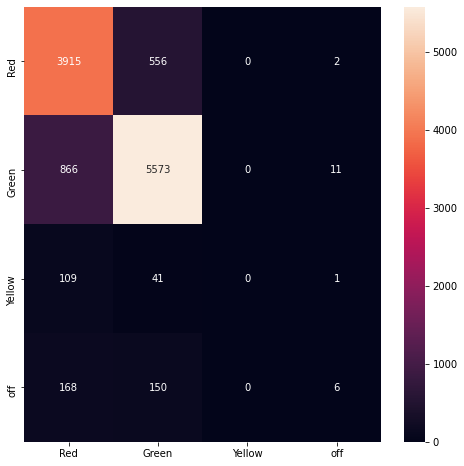

In [33]:
classes_names = ["Red", "Green", "Yellow", "off"]
df_cm = pd.DataFrame(cm.numpy(), index=classes_names,
                     columns=classes_names)

plt.figure(figsize=(8, 8))
fig = sns.heatmap(df_cm, annot=True, fmt='g')

Como anteriormente apontado, observa-se uma disparidade entre a acurácia do modelo durante o treinamento (aprox. 92%) e a precisão das predições (aprox. 83%), uma vez que temos uma grande distância na amostragem das classes.<br>
Este fato também se transfere para a matriz de confusão, a falta de imagens com anotações de objetos classificados como "off" e "Yellow" faz com que o modelo tenha muitos falsos positivos para estas classes.<br>
Existem técnicas para amenizar este problema, como *resampling* dos dados de treinamento, em que é realizada a criação sintética de novos dados para uma determinada classe, ou então são feitas cópias dos dados de uma mesma classe, estas técnicas são conhecidas como *oversampling*.